In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
path = r'\Deep Learning\datasets\digits'
path_train = path + r'\train.csv'
path_test = path + r'\test.csv'

In [176]:
data_train = np.array(pd.read_csv(path_train))
data_test = np.array(pd.read_csv(path_test))

In [177]:
def one_hot(data, num_classes):
    new_data = np.zeros((data.shape[0], num_classes))
    new_data[np.arange(data.shape[0]), data] = 1
    return new_data

In [178]:
X_train = data_train[:, 1:] / 255.0
y_train = one_hot(data_train[:, 0], 10)

X_test = data_test / 255.0

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_train = y_train.astype('float32')

In [179]:
def im2col_strided(x, field_height, field_width, padding=1, stride=1):
    m, H, W, C = x.shape
    out_h = (H + 2 * padding - field_height) // stride + 1
    out_w = (W + 2 * padding - field_width) // stride + 1
    x_padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
    shape = (m, out_h, out_w, field_height, field_width, C)
    strides = (
        x_padded.strides[0],
        stride * x_padded.strides[1],
        stride * x_padded.strides[2],
        x_padded.strides[1],
        x_padded.strides[2],
        x_padded.strides[3]
    )
    return np.lib.stride_tricks.as_strided(x_padded, shape=shape, strides=strides), out_h, out_w

In [180]:
def fast_convolution(x, W, b, padding=1, stride=1):
    m, H, W_in, C = x.shape
    f_h, f_w, _, num_filters = W.shape
    x_strided, out_h, out_w = im2col_strided(x, f_h, f_w, padding, stride)
    out = np.einsum('mxyhwc,hwck->mxyk', x_strided, W, optimize='optimal')
    out += b
    return out.reshape(m, out_h, out_w, num_filters)

In [181]:
def fast_convolution_backprop(x, W, dout, padding=1, stride=1):
    m, H, W_in, C = x.shape
    f_h, f_w, _, num_filters = W.shape
    x_strided, out_h, out_w = im2col_strided(x, f_h, f_w, padding, stride)
    dout_reshaped = dout.reshape(m, out_h, out_w, num_filters)
    
    dW = np.einsum('mxyhwc,mxyk->hwck', x_strided, dout_reshaped, optimize='optimal')
    
    db = np.sum(dout_reshaped, axis=(0, 1, 2), keepdims=True)
    
    dx_strided = np.einsum('mxyk,hwck->mxyhwc', dout_reshaped, W, optimize='optimal')
    dx_padded = np.zeros((m, H + 2 * padding, W_in + 2 * padding, C), dtype=x.dtype)
    
    for h in range(f_h):
        for w in range(f_w):
            dx_padded[:, h:h + stride*out_h:stride, w:w + stride*out_w:stride, :] += dx_strided[:, :, :, h, w, :]
    
    dx = dx_padded[:, padding:-padding, padding:-padding, :] if padding > 0 else dx_padded
    return dx, dW, db

In [182]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [183]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / np.sum(x_exp, axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [184]:
def CCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred-y # CCE + softmax
    return -np.mean(y*np.log(y_pred+epsilon))

In [185]:
def accuracy(y, y_pred):
    return np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))

In [186]:
# Conv Layer
IN_CHANNELS = 1
OUT_CHANNELS = 4
KERNEL = (3, 3)
STRIDE = 1
PADDING = 1

conv_W = np.random.randn(KERNEL[0], KERNEL[1], IN_CHANNELS, OUT_CHANNELS) * 0.1
conv_b = np.zeros((1, 1, 1, OUT_CHANNELS))

conv_out = (X_train.shape[1], X_train.shape[2], OUT_CHANNELS)

In [187]:
w_in = np.prod(conv_out)
n_hidden = 64
n_OUTPUTS = y_train.shape[1]

In [188]:
W0 = np.random.randn(w_in, n_hidden) * np.sqrt(2/w_in)
b0 = np.zeros((1, n_hidden))

W1 = np.random.randn(n_hidden, n_OUTPUTS) * np.sqrt(2/n_hidden)
b1 = np.zeros((1, n_OUTPUTS))

params = [conv_W, conv_b, W0, b0, W1, b1]
len_params = len(params)

In [189]:
# Adam optimizer settings
lr = 0.0005
current_lr = lr
decay = 0
m = [0] * len_params
v = [0] * len_params
beta_1 = 0.9
beta_2 = 0.999
t = 1
epsilon_adam = 1e-8

In [190]:
def optimizer_adam(grads, i):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads
    v[i] = beta_2 * v[i] + (1 - beta_2) * grads**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [191]:
def pre_update():
    global current_lr
    if decay:
        current_lr = lr * (1 / (1 + decay * t))

In [192]:
def step():
    global t
    t += 1

In [193]:
def update_params(grads):
    pre_update()
    for i in range(len_params):
        params[i] -= current_lr * optimizer_adam(grads[i], i)
    step()

In [194]:
def forward(x):
    global conv_out, conv_a, flat, z0, a0, z1, a1

    conv_out = fast_convolution(x, conv_W, conv_b, padding=PADDING, stride=STRIDE)
    conv_a = ReLU(conv_out)
    flat = conv_a.reshape(conv_a.shape[0], -1)
    
    z0 = flat @ W0 + b0
    a0 = ReLU(z0)

    z1 = a0 @ W1 + b1
    a1 = softmax(z1)

    return a1


In [195]:
def backward(x=None, y=None, outp=None, deltas=None, learn=True):
    if y is not None:
        dL = CCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('there is no (y) or (deltas).')
    m = dL.shape[0]
    # dL *= softmax(z1, derv=True)

    dW1 = a0.T @ dL / m
    db1 = dL.sum(axis=0, keepdims=True) / m

    da0 = dL @ W1.T
    dz0 = da0 * ReLU(z0, derv=True)

    dW0 = flat.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    dflat = dz0 @ W0.T
    dconv_a = dflat.reshape(conv_a.shape)
    dconv = dconv_a * ReLU(conv_out, derv=True)

    dx_conv, dconv_W, dconv_b = fast_convolution_backprop(x, conv_W, dconv, padding=PADDING, stride=STRIDE)

    grads = dconv_W, dconv_b, dW0, db0, dW1, db1

    if learn:
        update_params(grads)

    return dx_conv, grads

In [196]:
def train(x, y, epochs=50, batch_size=128, print_every=0.1):
    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        num_batches = 0
        
        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            preds = forward(x_batch)
            loss = CCE(y_batch, preds)
            acc = accuracy(y_batch, preds)
            epoch_loss += loss
            epoch_acc += acc
            num_batches += 1
            
            backward(x_batch, y_batch, outp=preds, learn=True)
            print(f"Epoch {epoch}, Batch {i//batch_size + 1}", end='\r')
        
        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches
        losses.append(avg_loss)
        accuracies.append(avg_acc)
        if epoch % max(1, int(epochs * print_every)) == 0:
            print(f'Epoch: [{epoch}/{epochs}]> Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}')
    return losses, accuracies

In [197]:
history_loss, history_acc = train(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=128,
    print_every=0.1
)

Epoch: [1/10]> Loss: 0.0598, Acc: 0.8468
Epoch: [2/10]> Loss: 0.0249, Acc: 0.9271
Epoch: [3/10]> Loss: 0.0193, Acc: 0.9433
Epoch: [4/10]> Loss: 0.0154, Acc: 0.9540
Epoch: [5/10]> Loss: 0.0128, Acc: 0.9623
Epoch: [6/10]> Loss: 0.0108, Acc: 0.9673
Epoch: [7/10]> Loss: 0.0094, Acc: 0.9720
Epoch: [8/10]> Loss: 0.0081, Acc: 0.9758
Epoch: [9/10]> Loss: 0.0074, Acc: 0.9772
Epoch: [10/10]> Loss: 0.0065, Acc: 0.9810


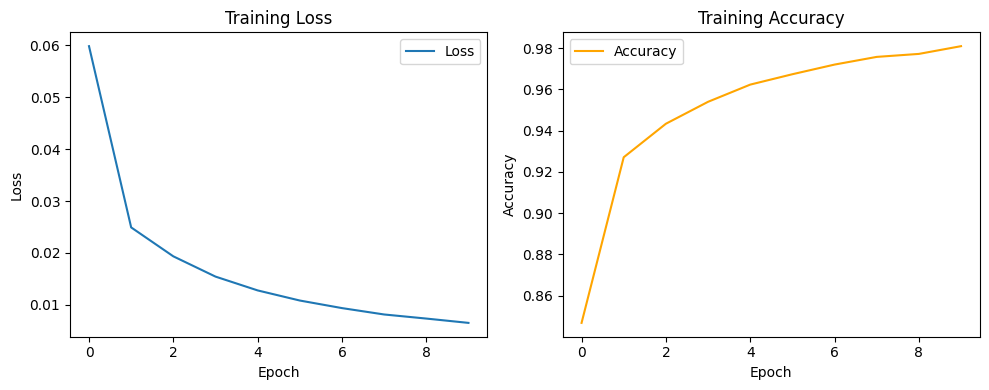

In [198]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [199]:
def predict_and_show(x_test):
    idx = np.random.randint(0, x_test.shape[0])
    img = x_test[idx:idx+1]
    preds = forward(img)
    pred_digit = np.argmax(preds, axis=1)[0]
    conv_output = conv_a[0]
    num_channels = conv_output.shape[-1]
    fig, axes = plt.subplots(1, num_channels + 2, figsize=(3*(num_channels+2), 4))
    axes[0].imshow(img[0, :, :, 0], cmap='gray')
    axes[0].set_title("Test Image")
    axes[0].axis('off')
    for i in range(num_channels):
        axes[i+1].imshow(conv_output[:, :, i], cmap='gray')
        axes[i+1].set_title(f"Channel {i}")
        axes[i+1].axis('off')
    axes[-1].text(0.5, 0.5, f'Prediction:\n{pred_digit}', fontsize=18, ha='center', va='center')
    axes[-1].set_title("Prediction")
    axes[-1].axis('off')
    plt.tight_layout()
    plt.show()

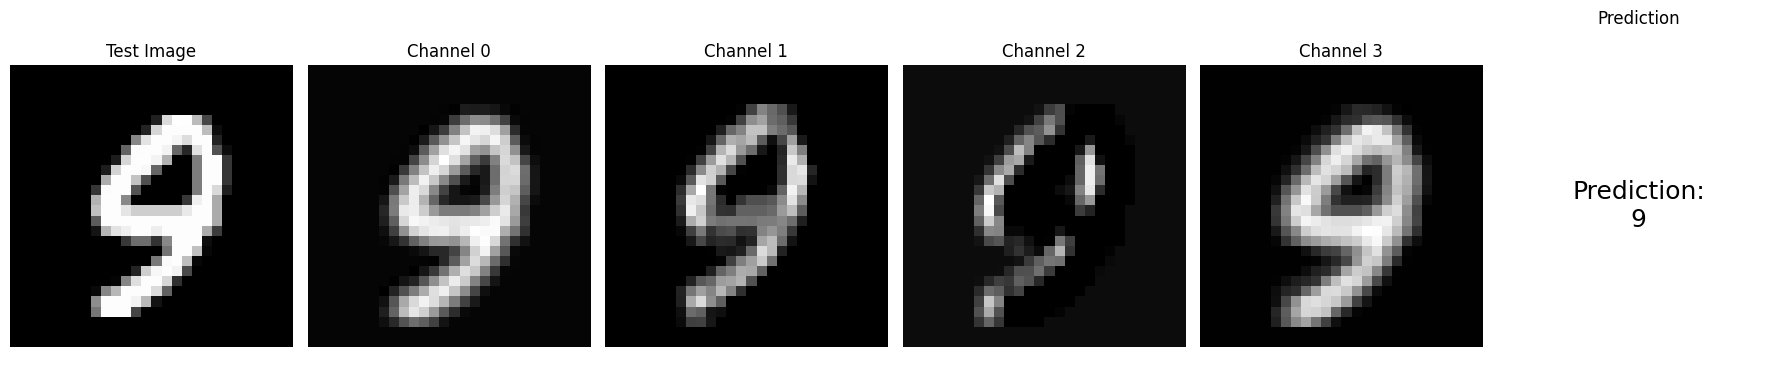

In [200]:
predict_and_show(X_test)